In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

In [3]:
data = pd.read_csv(r"C:\Users\Milan Anand Raj\Desktop\KNOWLEDGEEDGEAI\PET\pets_mockdata\Technical_Phase_Data\technical_phase_data.csv")
data.head()

,ID,date,merch_category,merch_postal_code,transaction_type,spendamt,nb_transactions
0,1,2019-01-01,Grocery Stores/Supermarkets,8700000,ONLINE,11238.128450,160
1,1,2019-01-01,Grocery Stores/Supermarkets,500034,ONLINE,12848.165221,183
2,2,2019-01-01,Grocery Stores/Supermarkets,110621,ONLINE,12116.165569,173
3,3,2019-01-01,Hotels/Motels,8900000,OFFLINE,7745.998879,38
4,4,2019-01-01,Restaurants,111941,OFFLINE,6927.424754,173


In [4]:
txn_channel_col = "transaction_type"
category_col = "merch_category"
time_col = "date"
postal_code_col = "merch_postal_code"
num_txns_col = "nb_transactions"

Select the week for which we have the ground truth contact matrix.
The ground truth matrix is being taken from this([text](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697)) paper and this([text](https://github.com/kieshaprem/synthetic-contact-matrices/blob/master/generate_synthetic_matrices/output/syntheticmatrices/contact_others.rdata)) associated github repo.

In [5]:
week ="2021-01-05"

We will calculate contact matrix for each city and then average them up to get the contact matrix for Columbia 

In [6]:
def categorize_city(code):
    if code.startswith("5"):
        return "Medellian"
    elif code.startswith("11"):
        return "Bogota"
    elif code.startswith("70"):
        return "Brasilia"
    else:
        return "Santiago"

To ensure that the estimated Consumption distribution is private, we will use the private version of number of transactions for each categroy

In [7]:
from DP_epidemiology.contact_matrix import get_private_counts
categories = sorted(data[category_col].unique())
cities = data[postal_code_col].astype(str).apply(categorize_city).unique()
transactions_per_city = []
for city in cities:
    start_date = datetime.strptime(week, '%Y-%m-%d')
    end_date = datetime.strptime(week, '%Y-%m-%d')
    print(f"City: {city}")
    transactions_per_category = get_private_counts(data, categories=categories, start_date=start_date, end_date=end_date, city=city, epsilon=1.0)
    transactions_per_city.append(list(transactions_per_category.values()))

City: Santiago
City: Medellian
City: Bogota
City: Brasilia


In [8]:
contact_others = pd.read_csv('contact_others.csv')
contact_others = np.array(contact_others)

In [18]:
transactions_per_city

[[665.827343044052,
  2376.0030054715944,
  4287.216254772609,
  63941.44098236439,
  21478.388863581316,
  40690.41606936624,
  2963.936491985296,
  5094.1112587002735,
  33376.344825964065,
  3277.412704119104],
 [-10.471957055996297,
  6140.521392653215,
  -2593.3432371460517,
  3218.708044630042,
  2882.8266155488673,
  -118.73193866793521,
  -1502.70368483887,
  2643.1117283735766,
  2515.2197469338525,
  2010.369461726336],
 [909.4191757659195,
  14061.87451760006,
  10965.389937129481,
  174970.32876629836,
  40193.28386099822,
  98156.80895732576,
  4871.752947048472,
  10026.12926489293,
  74465.54906523543,
  2910.016018267648],
 [-3542.2378675749783,
  1250.3608001315356,
  1736.475733452081,
  59610.73284853197,
  14309.168756153636,
  37408.784637817975,
  302.2175965746237,
  2275.2427407967584,
  22940.966562785838,
  2720.585656936167]]

## Estimating with tensorflow (which does the backpropogation based on the flow graph)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

N = np.array(transactions_per_city).reshape((len(cities), len(categories))).astype(np.float64)

P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector
num_age_bins = len(P)

# epsilon = 1e-10  # Small value to avoid division by zero

P_var = tf.Variable(np.random.rand(num_age_bins), dtype=tf.float64)
W = tf.Variable(np.ones([len(categories), num_age_bins]) * 1/num_age_bins, dtype=tf.float64)

# Loss function based on residuals
def loss_fn():
    age_bins = tf.matmul(N, W)
    # epsilon = 1e-10 # Small value to avoid division by zero
    contact_matrix = tf.reduce_sum([
    tf.matmul(tf.reshape(x, (-1, 1)), tf.reshape(1 / x, (1, -1)))
    for x in tf.unstack(age_bins, axis=0)], axis=0)/len(cities)
    K = contact_matrix*(P*P_var)
    K = (K + tf.transpose(K))/2
    estimated_C = K/P
    residuals = estimated_C - contact_others
    return tf.reduce_sum(tf.square(residuals)) +tf.reduce_sum(tf.square(1- tf.reduce_sum(W, axis=1))) + tf.reduce_sum(tf.square(tf.minimum(W, tf.zeros_like(W)))) +  tf.reduce_sum(tf.square(tf.minimum(P_var, tf.zeros_like(P_var)) + tf.minimum(tf.ones_like(P_var)-P_var, tf.zeros_like(P_var))))


optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
iteration_residuals = []

# Run the training loop on the GPU
# with tf.device('/GPU:0'):
for step in range(5000):  # Adjust max iterations as needed
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, [W, P_var])

    # Apply gradients
    optimizer.apply_gradients(zip(grads, [W, P_var]))

    iteration_residuals.append(loss.numpy())
    if step % 100 == 0:
        print(f'Step: {step}, Loss: {loss.numpy()}')

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()

Step: 0, Loss: 94.10587900174727
Step: 100, Loss: 33.359764471824434
Step: 200, Loss: 31.544671445447932
Step: 300, Loss: 31.413592926334598
Step: 400, Loss: 31.40243082658344
Step: 500, Loss: 31.40212694394862
Step: 600, Loss: 31.402122757334677
Step: 700, Loss: 31.402123427405275
Step: 800, Loss: 31.402122713168243
Step: 900, Loss: 31.402122705699163
Step: 1000, Loss: 31.40212491914406
Step: 1100, Loss: 31.4021226954282
Step: 1200, Loss: 31.402122691606444
Step: 1300, Loss: 31.40213079580314
Step: 1400, Loss: 31.402122686265916
Step: 1500, Loss: 31.402122684024533
Step: 1600, Loss: 31.402140614669783
Step: 1700, Loss: 31.40212268161008
Step: 1800, Loss: 31.40212268005513
Step: 1900, Loss: 31.40216548637534
Step: 2000, Loss: 31.402122681491136
Step: 2100, Loss: 31.4021226778284
Step: 2200, Loss: 31.402122677259698
Step: 2300, Loss: 31.402123758030374
Step: 2400, Loss: 31.402122676221257
Step: 2500, Loss: 31.402122675537353
Step: 2600, Loss: 31.402124518646147
Step: 2700, Loss: 31.4021

KeyboardInterrupt: 

In [22]:
age_bins = tf.matmul(N, W)
# epsilon = 1e-10
contact_matrix = tf.reduce_sum([
tf.matmul(tf.reshape(x, (-1, 1)), tf.reshape(1 / x, (1, -1)))
for x in tf.unstack(age_bins, axis=0)], axis=0)/len(cities)
K = contact_matrix*(P*P_var)
# print(age_bins)  
# K = tf.matmul(tf.transpose(age_bins), (P*P_var)/age_bins)
K = (K + tf.transpose(K))/2
estimated_C = K/P

In [23]:
estimated_C

<tf.Tensor: shape=(16, 16), dtype=float64, numpy=
array([[ 8.70317473e-02,  9.83703426e-02,  3.17915851e-02,
         1.75832026e-01,  1.08452084e-01,  2.66305331e-02,
        -1.22106419e-03, -1.11425751e-01,  8.70958947e-02,
         1.10584045e-01, -9.24561628e-03,  3.46535118e-02,
         9.10534029e-03,  4.25429530e-02,  3.21016247e-01,
        -2.47829097e-01],
       [ 9.75230391e-02, -1.65246331e-01,  1.65918444e-01,
         2.88289385e-01,  2.28760713e-01,  1.76733539e-01,
         8.58224575e-02,  2.31624119e-01,  1.75760448e-01,
        -1.76856102e-01,  1.42016268e-01, -1.49730643e-01,
         1.19434724e-01, -3.91733717e-02, -4.09051821e-01,
         2.47612447e-01],
       [ 3.06820772e-02,  1.61519217e-01,  2.34562759e-01,
         6.81743104e-01,  4.52804284e-01,  1.20589528e-01,
         1.17694125e-01, -9.31050648e-02,  5.45993534e-02,
         2.55280627e-01, -2.30280854e-02,  1.98963205e-01,
         1.05155572e-01,  1.55119419e-01,  6.42706084e-01,
        -2.51

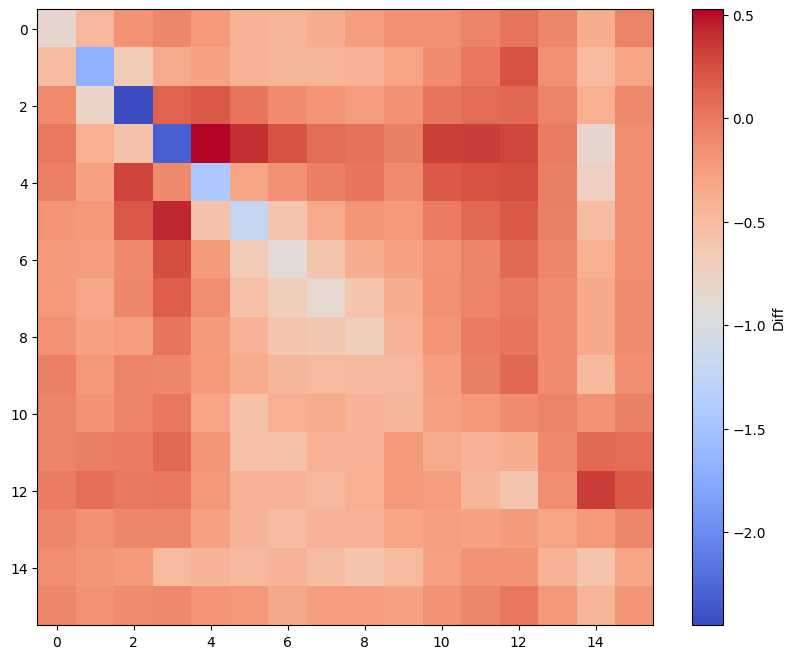

In [19]:
diff = estimated_C - contact_others

plt.figure(figsize=(10, 8))
plt.imshow(diff, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

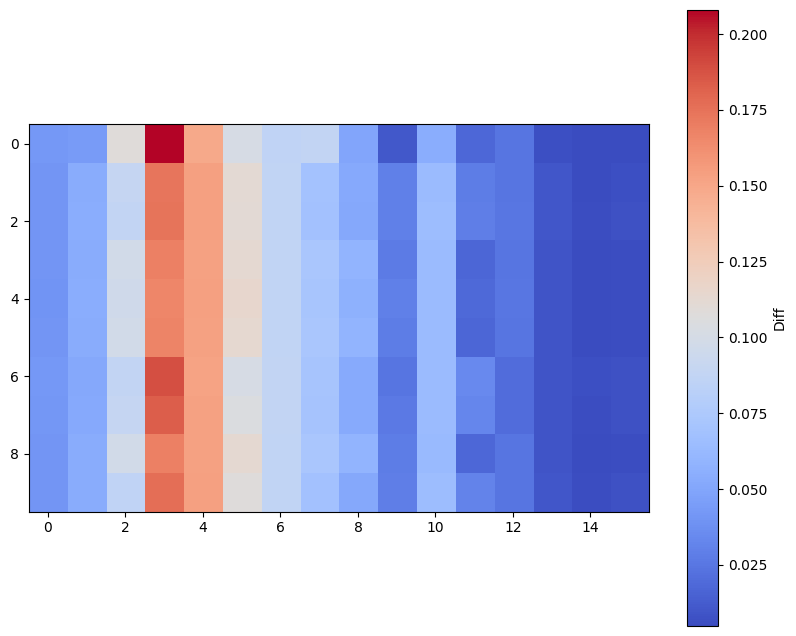

In [36]:
# diff = estimated_C - contact_others

plt.figure(figsize=(10, 8))
plt.imshow(W, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

In [39]:
# save W in a csv file and make one extra column for categories
# W = W.numpy()
W = pd.DataFrame(W*100)
W['categories'] = categories
W.to_csv('consumption_distribution.csv', index=False)

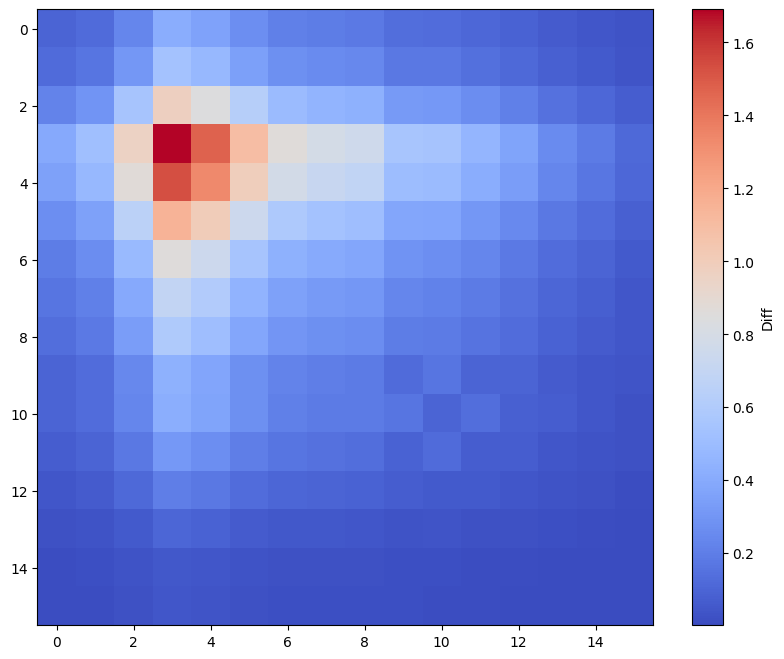

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(estimated_C, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

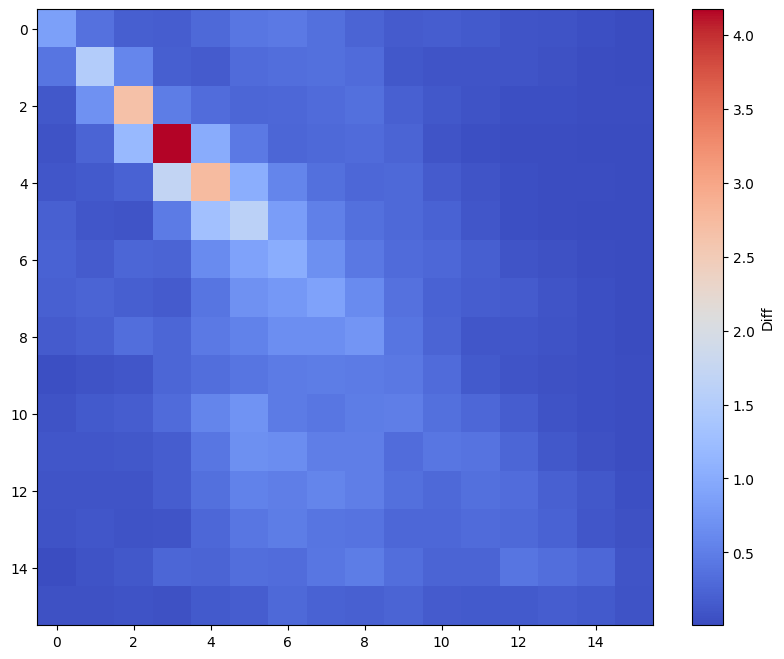

In [58]:
plt.figure(figsize=(10, 8))
plt.imshow(contact_others, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

In [48]:
tf.reduce_sum(W, axis = 1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.99999994, 1.        , 1.0000001 , 0.99999976, 1.        ,
       0.99999976, 0.9999998 , 0.99999976, 1.        , 1.0000001 ],
      dtype=float32)>

In [49]:
P_var

<tf.Variable 'Variable:0' shape=(16,) dtype=float32, numpy=
array([0.1028751 , 0.17777166, 0.57022214, 1.4881366 , 1.2576891 ,
       0.773256  , 0.46321404, 0.34541705, 0.27969265, 0.13417491,
       0.10667394, 0.0778164 , 0.04607543, 0.01719388, 0.00633588,
       0.00258659], dtype=float32)>